In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import xlogy
import h5py

from sklearn.metrics import accuracy_score

In [0]:
def load_dataset():

  """Loads the Cat vs Non-Cat dataset

    Returns
    -------
    X_train, y_train, X_test, y_test, classes: Arrays
      Dataset splitted into train and test with classes
  """
  
  train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:])
  train_set_y_orig = np.array(train_dataset["train_set_y"][:])

  test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:])
  test_set_y_orig = np.array(test_dataset["test_set_y"][:])

  classes = np.array(test_dataset["list_classes"][:])
  
  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
def relu(Z):

  """Applies relu function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying relu function
  """
  
  return np.maximum(Z, 0)

In [0]:
def relu_prime(Z):
  
  """Applies differentiation of relu function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying diff of relu function
  """

  return (Z>0).astype(Z.dtype)

In [0]:
def sigmoid(Z):

  """Applies sigmoid function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying sigmoid function
  """    
  
  return 1/(1+np.power(np.e, -Z))

In [0]:
def sigmoid_prime(Z):

  """Applies differentiation of sigmoid function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying diff of sigmoid function
  """
  
  return Z * (1-Z)

In [0]:
def leaky_relu(Z, alpha=0.01):

  """Applies leaky relu function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value
    alpha: float
      Negative slope coefficient

    Returns
    -------
    A: same shape as input
      Value after applying leaky relu function
  """   

  return np.where(Z > 0, Z, Z * alpha)

In [0]:
def leaky_relu_prime(Z, alpha=0.01):

  """Applies differentiation of leaky relu function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value
    alpha: float
      Negative slope coefficient

    Returns
    -------
    A: same shape as input
      Value after applying diff of leaky relu function
  """

  dz = np.ones_like(Z)
  dz[Z < 0] = alpha
  return dz

In [0]:
def tanh(Z):

  """Applies tanh function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying tanh function
  """   

  return np.tanh(Z)

In [0]:
def tanh_prime(Z):
  
  """Applies differentiation of tanh function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying diff of tanh function
  """

  return 1-(tanh(Z)**2)

In [0]:
def get_activation_function(name):

  """Returns function corresponding to an activation name

    Arguments
    ---------
    name: string
      'relu', 'leaky_relu', 'tanh' or 'sigmoid' activation

    Returns
    -------
    Corresponding activation function
  """

  if name=='relu':
    return relu
  elif name=='sigmoid':
    return sigmoid
  elif name=='leaky_relu':
    return leaky_relu
  elif name=='tanh':
    return tanh
  else:
    raise ValueError('Only "relu", "leaky_relu", "tanh" and "sigmoid" supported')

In [0]:
def get_derivative_activation_function(name):

  """Returns differentiation function corresponding to an activation name

  Arguments
  ---------
  name: string
    'relu', 'leaky_relu', 'tanh' or 'sigmoid' activation

  Returns
  -------
  Corresponding diff of activation function
  """

  if name=='relu':
    return relu_prime
  elif name=='sigmoid':
    return sigmoid_prime
  elif name=='leaky_relu':
    return leaky_relu_prime
  elif name=='tanh':
    return tanh_prime
  else:
    raise ValueError('Only "relu", "leaky_relu", "tanh" and "sigmoid" supported')

In [0]:
def initialize_layer_weights(n_l_1, n_l, random_state=0):

  """Initializes random weights and bias for a layer l

    Arguments
    ---------
    n_l_1: int
      Number of neurons in previous layer (l-1)
    n_l_1: int
      Number of neurons in current layer (l)
    random_state: int
      Random seed

    Returns
    -------
    dict
      Contains the randomly initialized weights and bias arrays

      The keys for weights and bias arrays in the dict are 'W1', 'b1', 'W2' and 'b2'
  """

  np.random.seed(random_state)

  wl = np.random.randn(n_l_1, n_l) * np.sqrt(2/n_l_1)
  bl = np.random.randn(1, n_l) * np.sqrt(2/n_l_1)

  return {'wl': wl, 'bl': bl}

In [0]:
class Dense:
  
  """Returns a dense layer with randomly initialized weights and bias

    Arguments
    ---------
    input_dim: int
      Number of neurons in previous layer.
    units: int
      Number of neurons in the layer.
    activation: str
      Activation function to use. 'relu', 'leaky_relu', 'tanh' or 'sigmoid'

    Returns
    -------
    Dense layer
      An instance of the Dense layer initialized with random params.
  """

  def __init__(self, input_dim, units, activation, random_state=0):

    params = initialize_layer_weights(input_dim, units, random_state)

    self.units = units
    self.W = params['wl']
    self.b = params['bl']
    self.activation = activation
    self.Z = None
    self.A = None
    self.dz = None
    self.da = None
    self.dw = None
    self.db = None

In [0]:
def forward_prop(X, model):
  
  """Performs forward propagation and calculates output value

    Arguments
    ---------
    X: array_like
      Data
    model: list
      List containing the layers

    Returns
    -------
    Model: list
      List containing layers with updated 'Z' and 'A'
  """

  for i in range(len(model)):

    if i==0:
      X_l_1 = X.copy()
    else:
      X_l_1 = model[i-1].A

    model[i].Z = np.dot(X_l_1, model[i].W) + model[i].b
    model[i].A = get_activation_function(model[i].activation)(model[i].Z)
    
  return model

In [0]:
def calculate_loss(y, model):

  """Calculate the entropy loss

    Arguments
    --------- 
    y: array-like
      True lables
    model: list
      List containing the layers

    Returns
    -------
    loss: float
      Entropy loss
  """

  m = y.shape[0]
  A = model[-1].A

  return np.squeeze(-(1./m)*np.nansum(np.multiply(y, np.log(A+1e-15))+np.multiply(np.log(1-A+1e-15), 1-y)))     # Squeeze will convert [[cost]] to 'cost' float variable

In [0]:
def backward_prop(X, y, model):

  """Performs forward propagation

    Arguments
    ---------
    X: array_like
      Data
    y: array_like
      True labels
    model: list
      List containing the layers

    Returns
    -------
    model: list
      List containing the layers with calculated 'dw' and 'db'
  """

  m = X.shape[0]

  for i in range(len(model)-1, -1, -1):

    if i==len(model)-1:
      model[i].dz = model[-1].A - y
      model[i].dw = 1./m * np.dot(model[i-1].A.T, model[i].dz)
      model[i].db = 1./m * np.sum(model[i].dz, axis=0, keepdims=True)

      model[i-1].da = np.dot(model[i].dz, model[i].W.T)

    else:

      model[i].dz = np.multiply(np.int64(model[i].A>0), model[i].da) * get_derivative_activation_function(model[i].activation)(model[i].Z)

      if i!=0:
        model[i].dw = 1./m * np.dot(model[i-1].A.T, model[i].dz)
      else:
        model[i].dw = 1./m * np.dot(X.T, model[i].dz)
      model[i].db = 1./m * np.sum(model[i].dz, axis=0, keepdims=True)
      if i!=0:
        model[i-1].da = np.dot(model[i].dz, model[i].W.T)

  return model

In [0]:
def update_weights(model, learning_rate=0.01):

  """Updates weights of the layers

    Arguments
    ---------
    model: list
      List containing the layers
    learning_rate: int, float
      Learning rate for the weight update

    Returns
    -------
    model: list
      List containing the layers
  """

  for i in range(len(model)):
    model[i].W -= learning_rate*model[i].dw
    model[i].b -= learning_rate*model[i].db
    
  return model

In [0]:
def predict(X, y, model):
    
  """Using the learned parameters, predicts a class for each example in X
  
  Arguments
  ---------
  X: array_like
    Data
  y: array_like
    True Labels
  model: list
    List containing the layers
  
  Returns
  -------
  predictions: array_like
    Vector of predictions of our model
  """
  
  model1 = forward_prop(X, model.copy())
  predictions = np.where(model1[-1].A > 0.5, 1, 0)
  
  return predictions

In [0]:
def print_mislabeled_images(classes, X, y, p):
    
  """Plots images where predictions and truth were different.
  
  Arguments
  ---------
  classes: List
    Output classes
  X: array_like
    Data
  y: array_like
    True Labels
  p: array-like
    Predictions
  """

  a = p + y
  mislabeled_indices = np.asarray(np.where(a == 1))
  plt.rcParams['figure.figsize'] = (40.0, 40.0)
  num_images = len(mislabeled_indices[0])
  for i in range(num_images):
      index = mislabeled_indices[0][i]
      plt.subplot(2, num_images, i + 1)
      plt.imshow(X[index, :].reshape(64,64,3), interpolation='nearest')
      plt.axis('off')
      plt.title("Prediction: " + classes[int(p[index, 0])].decode("utf-8") + " \n Class: " + classes[y[index, 0]].decode("utf-8"))

In [0]:
X_train, y_train, X_test, y_test, classes = load_dataset()
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(209, 64, 64, 3)
(209, 1)
(50, 64, 64, 3)
(50, 1)


In [0]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [0]:
X_train = X_train/255.
X_test = X_test/255.

In [0]:
shuffled_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffled_indices, :]
y_train = y_train[shuffled_indices, :]

In [0]:
batch_size = 64

In [0]:
total_batches = np.ceil(len(X_train)/batch_size).astype('int')
batches = []

for b in range(total_batches):
  last_index = min(b*batch_size+batch_size, len(X_train))
  X_batch = X_train[b*batch_size:last_index, :]
  y_batch = y_train[b*batch_size:last_index, :]
  batches.append((X_batch, y_batch))

In [28]:
# Size of all batches

[len(i[0]) for i in batches]

[64, 64, 64, 17]

In [0]:
random_state = 42
epochs = 1000

model = []
model.append(Dense(input_dim = X_train.shape[1], units=20, activation='relu', random_state=random_state))
model.append(Dense(input_dim = 20, units=16, activation='relu', random_state=random_state))
model.append(Dense(input_dim = 16, units=8, activation='relu', random_state=random_state))
model.append(Dense(input_dim = 8, units=4, activation='relu', random_state=random_state))
model.append(Dense(input_dim = 4, units=y_train.shape[1], activation='sigmoid', random_state=random_state))

In [30]:
for i in range(epochs+1):
  for X_batch, y_batch in batches:
    model = forward_prop(X_batch, model)
    loss = calculate_loss(y_batch, model)
    model = backward_prop(X_batch, y_batch, model)
    model = update_weights(model, 5e-3)
 
  if i%(epochs/10)==0:
    print('Epoch: {}\tLoss: {:.6f}\tTrain Accuracy: {:.3f}\tTest Accuracy: {:.3f}'.format(i, loss, accuracy_score(y_train, predict(X_train, y_train, model)), accuracy_score(y_test, predict(X_test, y_test, model))))

Epoch: 0	Loss: 0.673415	Train Accuracy: 0.656	Test Accuracy: 0.320
Epoch: 100	Loss: 0.551569	Train Accuracy: 0.756	Test Accuracy: 0.460
Epoch: 200	Loss: 0.475155	Train Accuracy: 0.842	Test Accuracy: 0.640
Epoch: 300	Loss: 0.378862	Train Accuracy: 0.928	Test Accuracy: 0.800
Epoch: 400	Loss: 0.193319	Train Accuracy: 0.962	Test Accuracy: 0.740
Epoch: 500	Loss: 0.152461	Train Accuracy: 0.976	Test Accuracy: 0.740
Epoch: 600	Loss: 0.125028	Train Accuracy: 0.990	Test Accuracy: 0.780
Epoch: 700	Loss: 0.104603	Train Accuracy: 0.990	Test Accuracy: 0.780
Epoch: 800	Loss: 0.089998	Train Accuracy: 0.990	Test Accuracy: 0.800
Epoch: 900	Loss: 0.078592	Train Accuracy: 0.990	Test Accuracy: 0.780
Epoch: 1000	Loss: 0.069864	Train Accuracy: 0.990	Test Accuracy: 0.780


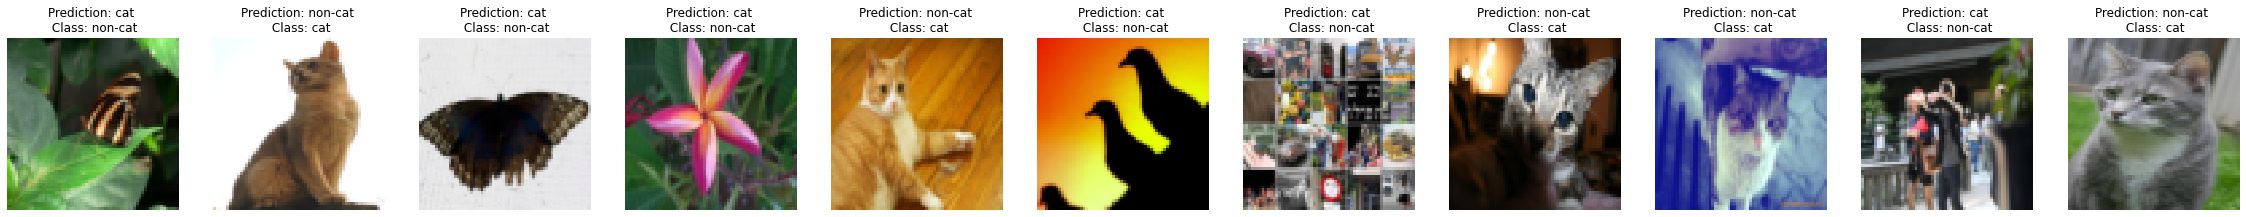

In [31]:
print_mislabeled_images(classes, X_test, y_test, predict(X_test, y_test, model))